# Project 01


## Problem 1

Problem 1
Given the dataset in problem1.csv

A. Calculate the Mean, Variance, Skewness and Kurtosis of the data

B. Given a choice between a Normal Distribution and a T-Distribution, which one would you choose to model the data? Why?

C. Fit both distributions and prove or disprove your choice in B using methods presented in class.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t, skew, kurtosis, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("../Projects/Project01/problem1.csv")
# print(data.head())

# A. Calculate the Mean, Variance, Skewness, and Kurtosis
def first_4_moments(sample):
    n = len(sample)
    μ_hat = np.mean(sample)  # Mean
    sim_corrected = sample - μ_hat
    cm2 = np.mean(sim_corrected**2)  # Central moment (2nd moment)
    σ2_hat = np.var(sample, ddof=1)  # Variance
    skew_hat = np.mean(sim_corrected**3) / (cm2**1.5)  # Skewness
    kurt_hat = np.mean(sim_corrected**4) / (cm2**2)  # Kurtosis
    excess_kurt_hat = kurt_hat - 3  # Excess Kurtosis
    return μ_hat, σ2_hat, skew_hat, excess_kurt_hat

sample = data['X'][1:].to_numpy()
m, s2, sk, k = first_4_moments(sample)
print(f"Mean: {m}")
print(f"Variance: {s2}")
print(f"Skewness: {sk}")
print(f"Kurtosis (excess): {k}")

print(f"Mean diff = {m - np.mean(sample)}")
print(f"Variance diff = {s2 - np.var(sample, ddof=1)}")
print(f"Skewness diff = {sk - skew(sample)}")
print(f"Kurtosis diff = {k - kurtosis(sample, fisher=True)}")

Mean: 0.050366360906888966
Variance: 0.010314441602725719
Skewness: 0.12046167291008684
Kurtosis (excess): 0.22908332509377516
Mean diff = 0.0
Variance diff = 0.0
Skewness diff = 2.7755575615628914e-17
Kurtosis diff = 0.0


B: A Normal Distribution seems like the better choice to model it. The mean is 0.050, and the variance is 0.010, which are within normal ranges. The skewness is 0.120, indicating that the data is almost perfectly symmetric, with only a very slight rightward lean. The excess kurtosis is 0.229, showing that the tails of the data are slightly heavier than those of a perfect Normal Distribution but still fairly close. Since these values align closely with the properties of a Normal Distribution, it seems like a more natural fit than a T-Distribution, which is used for data with much heavier tails.


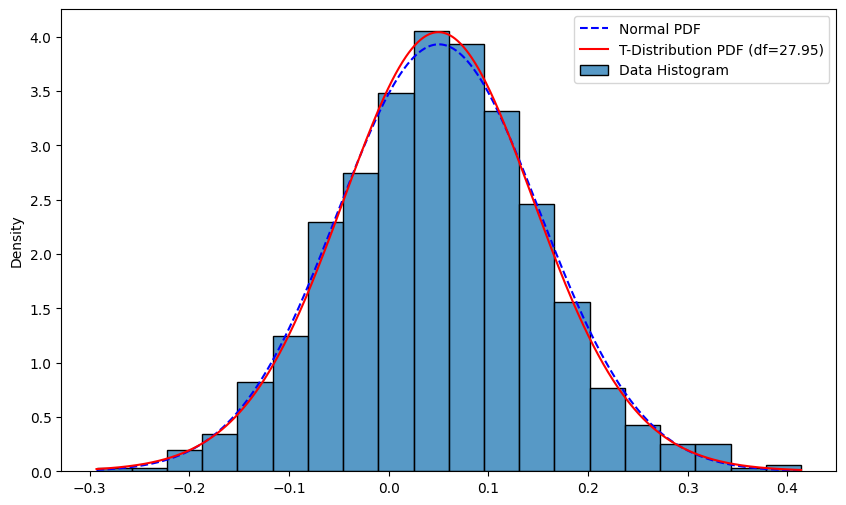

KS Test Results for Normal and T-Distribution：
Normal: D-stat=0.0127, p-value=0.9963
t_dist: D-stat=0.0127, p-value=0.9966
Result：t distribution is better. 


In [27]:
# C
data = sample
mu, sigma = norm.fit(data)
df, loc, scale = t.fit(data)

# 绘制直方图和PDF
x = np.linspace(min(data), max(data), 1000)
normal_pdf = norm.pdf(x, mu, sigma)
t_pdf = t.pdf(x, df, loc, scale)

plt.figure(figsize=(10, 6))
sns.histplot(data, kde=False, bins=20, stat='density', label='Data Histogram')
plt.plot(x, normal_pdf, label='Normal PDF', linestyle='--', color='blue')
plt.plot(x, t_pdf, label=f'T-Distribution PDF (df={df:.2f})', linestyle='-', color='red')
plt.legend()
plt.show()

ks_normal = kstest(data, 'norm', args=(mu, sigma))
ks_t = kstest(data, 't', args=(df, loc, scale))

print("KS Test Results for Normal and T-Distribution：")
print(f"Normal: D-stat={ks_normal.statistic:.4f}, p-value={ks_normal.pvalue:.4f}")
print(f"t_dist: D-stat={ks_t.statistic:.4f}, p-value={ks_t.pvalue:.4f}")

if ks_t.pvalue > ks_normal.pvalue:
    print("Result：t distribution is better. ")
else:
    print("Result: normal distribution is better.")

From this method t distribution is slightly better than normal distribution. In order to be more accuracy, we'll then use AIC and BIC methods.

In [25]:
# 3. 计算 AIC 和 BIC
# AIC/BIC 公式：-2 * log-likelihood + 2 * k (AIC) 或 log(n) * k (BIC)
# k 为参数数量，n 为样本量
n = len(data)

# 正态分布 log-likelihood
log_likelihood_normal = np.sum(np.log(norm.pdf(data, mu, sigma)))
aic_normal = -2 * log_likelihood_normal + 2 * 2  # 两个参数：mu 和 sigma
bic_normal = -2 * log_likelihood_normal + np.log(n) * 2

# t 分布 log-likelihood
log_likelihood_t = np.sum(np.log(t.pdf(data, df, loc, scale)))
aic_t = -2 * log_likelihood_t + 2 * 3  # 三个参数：df, loc, scale
bic_t = -2 * log_likelihood_t + np.log(n) * 3

print("AIC and BIC Comparison:")
print(f"Normal Distribution: AIC = {aic_normal:.2f}, BIC = {bic_normal:.2f}")
print(f"T-Distribution: AIC = {aic_t:.2f}, BIC = {bic_t:.2f}")

# 判断哪个分布更好
if aic_t < aic_normal:
    print("Based on AIC, T-Distribution fits better.")
else:
    print("Based on AIC, Normal Distribution fits better.")

if bic_t < bic_normal:
    print("Based on BIC, T-Distribution fits better.")
else:
    print("Based on BIC, Normal Distribution fits better.")

AIC and BIC Comparison:
Normal Distribution: AIC = -1731.60, BIC = -1721.78
T-Distribution: AIC = -1731.53, BIC = -1716.81
Based on AIC, Normal Distribution fits better.
Based on BIC, Normal Distribution fits better.


## Problem 2

Problem 2
Given the data in problem2.csv

A. Calculate the pairwise covariance matrix of the data.

B. Is the Matrix at least positive semi-definite? Why?

C. If not, find the nearest positive semi-definite matrix using Higham’s method and the
near-psd method of Rebenato and Jackel.

D. Calculate the covariance matrix using only overlapping data.

E. Compare the results of the covariance matrices in C and D. Explain the differences.

Note: the generating process is a covariance matrix with 1 on the diagonals and 0.99
elsewhere.

In [27]:
data = pd.read_csv("../Projects/Project01/problem2.csv")

In [4]:
# A. Calculate the pairwise covariance matrix
def calculate_pairwise_covariance_matrix(data):
    return data.cov()

def calculate_missing_covariance(data):
    complete_data = data.dropna()
    cov_matrix = complete_data.cov()
    return cov_matrix

cov_matrix = calculate_pairwise_covariance_matrix(data)
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


In [78]:
# # Test
# test_01 = pd.read_csv("../testfiles/data/test1.csv")
# print(calculate_pairwise_covariance_matrix(test_01))
# print(calculate_missing_covariance(test_01))

In [28]:
# B. Check if the matrix is positive semi-definite
def is_positive_semi_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues >= 0), eigenvalues
psd_status, eigenvalues = is_positive_semi_definite(cov_matrix)
print("Is the covariance matrix positive semi definite?", psd_status)

Is the covariance matrix positive semi definite? False


In [29]:
# C. Find the nearest positive semi-definite matrix using Higham’s method
def nearest_psd_higham(matrix):
    # Compute the symmetric part of the matrix
    sym_matrix = (matrix + matrix.T) / 2
    # Perform eigen-decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(sym_matrix)
    # Replace negative eigenvalues with zero
    eigenvalues[eigenvalues < 1e-8] = 1e-8
    # Reconstruct the matrix
    return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

nearest_psd_matrix = nearest_psd_higham(cov_matrix)
psd_status, _ = is_positive_semi_definite(nearest_psd_matrix)
print("Is the covariance matrix positive semi definite?", psd_status)
print("Nearest PSD Matrix (Higham):")
print(nearest_psd_matrix)

Is the covariance matrix positive semi definite? True
Nearest PSD Matrix (Higham):
[[1.61513295 1.44196041 0.89714421 1.78042572 1.43379434]
 [1.44196041 1.34696791 0.58508636 1.55455192 1.21140918]
 [0.89714421 0.58508636 1.29891579 1.11595578 1.07669233]
 [1.78042572 1.55455192 1.11595578 1.98316489 1.62137332]
 [1.43379434 1.21140918 1.07669233 1.62137332 1.40493616]]


In [30]:
def near_psd_rebonato_jackel(cov_matrix, epsilon=1e-8):
    # Step 1: Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Step 2: Replace negative eigenvalues with a small non-negative value
    eigenvalues[eigenvalues < 0] = epsilon

    # Step 3: Reconstruct the covariance matrix
    adjusted_cov_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    # Step 4: Rescale the matrix to match the original variances
    original_variances = np.diag(cov_matrix)
    scaling_factors = np.sqrt(original_variances / np.diag(adjusted_cov_matrix))
    scaling_matrix = np.diag(scaling_factors)
    final_cov_matrix = scaling_matrix @ adjusted_cov_matrix @ scaling_matrix

    return final_cov_matrix

nearest_psd_matrix02 = near_psd_rebonato_jackel(cov_matrix)
print("Nearest PSD Matrix (rebonato_jackel):")
print(nearest_psd_matrix02)

Nearest PSD Matrix (rebonato_jackel):
[[1.47048437 1.32652813 0.84725458 1.62496988 1.36381777]
 [1.32652813 1.25207795 0.55831928 1.43363198 1.16431726]
 [0.84725458 0.55831928 1.272425   1.05649629 1.06233291]
 [1.62496988 1.43363198 1.05649629 1.81446921 1.54604392]
 [1.36381777 1.16431726 1.06233291 1.54604392 1.39618646]]


In [36]:
# D. Calculate covariance matrix using only overlapping data
def covariance_overlapping(data):
    overlapping_data = data.dropna()  # Drop rows with missing values
    return overlapping_data.cov()

cov_matrix_overlapping = covariance_overlapping(data)
print("Covariance Matrix Using Overlapping Data:")
print(cov_matrix_overlapping)


Covariance Matrix Using Overlapping Data:
          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


E:
The nearest PSD matrix Higham and rebonato_jackel are closer to the original theoretical covariance structure because they adjusts the matrix mathematically to fix any issues. On the other hand, the covariance matrix from overlapping data shows the limits of the dataset since there isn’t enough data to make an accurate estimate. The Rebonato and Jackel method is indeed closer to the original matrix because it preserves the variances and adjusts the eigenvalues minimally. Higham’s method is more suitable when the goal is to minimize the Frobenius norm without constraints on scale.

## Problem 3

Problem 3 Given the data in problem3.csv

A. Fit a multivariate normal to the data.

B. Given that fit, what is the distribution of X2 given X1=0.6. Use the 2 methods described
in class. (Conditional)

C. Given the properties of the Cholesky Root, create a simulation that proves your
distribution of X2 | X1=0.6 is correct.


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import inv, cholesky
import statsmodels.api as sm

data = pd.read_csv("../Projects/Project01/problem3.csv")
# A. Fit a multivariate normal to the data
# Calculate the mean vector and covariance matrix
mean_vector = data.mean().values
cov_matrix = data.cov().values
print("Mean vector:", mean_vector)
print("Covariance matrix:\n", cov_matrix)

Mean vector: [0.04600157 0.09991502]
Covariance matrix:
 [[0.0101622  0.00492354]
 [0.00492354 0.02028441]]


In [7]:
# B. Distribution of X2 given X1=0.6
# Method 1: Conditional distribution formula
def conditional_distribution(x1_value, mean, cov):
    mu_x1, mu_x2 = mean[0], mean[1]
    sigma_x1x1, sigma_x2x2 = cov[0, 0], cov[1, 1]
    sigma_x1x2 = cov[0, 1]

    # Conditional mean and variance
    conditional_mean = mu_x2 + (sigma_x1x2 / sigma_x1x1) * (x1_value - mu_x1)
    conditional_variance = sigma_x2x2 - (sigma_x1x2 ** 2) / sigma_x1x1
    return conditional_mean, conditional_variance

x1_value = 0.6
cond_mean, cond_variance = conditional_distribution(x1_value, mean_vector, cov_matrix)
print("Conditional mean of X2 given X1=0.6:", cond_mean)
print("Conditional variance of X2 given X1=0.6:", cond_variance)


# Method 2: Using the OLS Method

# Perform OLS regression (X2 ~ X1)
X = sm.add_constant(data['x1'])  # Add constant term for the intercept
y = data['x2']

ols_model = sm.OLS(y, X).fit()

# Get the fitted values and the regression parameters
intercept, slope = ols_model.params
predicted_X2_given_X1 = intercept + slope * x1_value

# Print the conditional mean and the variance from OLS
print(f'Conditional mean of X2 given X1={x1_value} using OLS: {predicted_X2_given_X1}')

# To estimate the variance of X2 given X1=0.6, use the residuals from the OLS model
residuals = ols_model.resid
estimated_variance = np.var(residuals)

print(f'Estimated variance of X2 given X1 using OLS: {estimated_variance}')
print(f'Slope (beta_1): {slope}, Intercept: {intercept}')

Conditional mean of X2 given X1=0.6: 0.3683249958609775
Conditional variance of X2 given X1=0.6: 0.017898969645087522
Conditional mean of X2 given X1=0.6 using OLS: 0.3683249958609775
Estimated variance of X2 given X1 using OLS: 0.017881070675442437
Slope (beta_1): 0.48449591027977496, Intercept: 0.07762744969311251


In [65]:
# c
def simulate_conditional_distribution(x1_value, mean, cov, n_simulations=10000, threshold=0.05):
    # Cholesky decomposition
    chol_root = cholesky(cov)
    z = np.random.normal(size=(n_simulations, 2))  # Standard normal variables
    samples = mean + z @ chol_root.T  # Generate samples from multivariate normal

    # Find samples where X1 is approximately equal to the given value
    x1_samples = samples[:, 0]
    x2_samples = samples[:, 1]

    # Filter samples close to X1=x1_value
    close_samples = np.abs(x1_samples - x1_value) < threshold
    x2_given_x1_samples = x2_samples[close_samples]

    # Handle the case where no samples are found
    if len(x2_given_x1_samples) == 0:
        raise ValueError(f"No samples found for X1 close to {x1_value} within threshold {threshold}.")

    return x2_given_x1_samples

# Updated simulation
try:
    simulated_x2 = simulate_conditional_distribution(x1_value, mean_vector, cov_matrix, n_simulations=100000000, threshold=0.05)
    simulated_mean = np.mean(simulated_x2)
    simulated_variance = np.var(simulated_x2)

    print("Simulated mean of X2 | X1=0.6:", simulated_mean)
    print("Simulated variance of X2 | X1=0.6:", simulated_variance)
except ValueError as e:
    print(e)

Simulated mean of X2 | X1=0.6: 0.34517989612039235
Simulated variance of X2 | X1=0.6: 0.015088302683434123


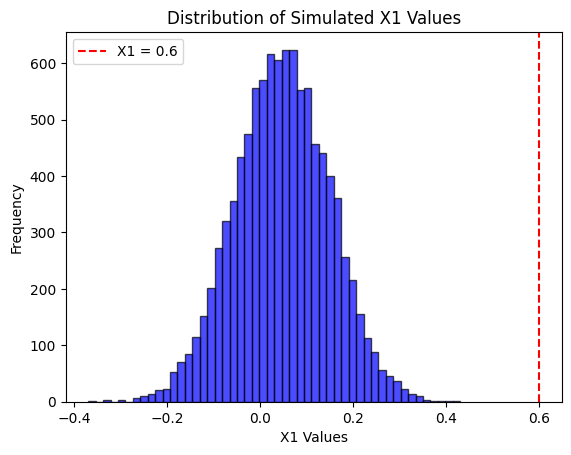

In [62]:
import matplotlib.pyplot as plt

# Simulate data without filtering to visualize X1 distribution
n_simulations = 10000
chol_root = cholesky(cov_matrix)
z = np.random.normal(size=(n_simulations, 2))  # Standard normal variables
samples = mean_vector + z @ chol_root.T

# Plot the histogram of X1 values
plt.hist(samples[:, 0], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=x1_value, color='red', linestyle='--', label=f"X1 = {x1_value}")
plt.title("Distribution of Simulated X1 Values")
plt.xlabel("X1 Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The histogram of X_1 values reveals that X_1 = 0.6 is far from the majority of the simulated values.

The simulated mean (0.3452) is close to the analytical mean (0.3683) but slightly lower. The simulated variance (0.0151) is also close to the analytical variance (0.0179) but slightly underestimated. The simulated mean and variance are slightly underestimated, likely due to the smaller sample size near X_1 = 0.6 and the threshold-based filtering (0.05).

## Problem 4

Problem 4
Given the data in problem4.csv

A. Simulate an MA(1), MA(2), and MA(3) process and graph the ACF and PACF of each.
What do you notice?

B. Simulate an AR(1), AR(2), and AR(3) process and graph the ACF and PACF of each.
What do you notice?

C. Examine the data in problem4.csv. What AR/MA process would you use to model the
data? Why?

D. Fit the model of your choice in C along with other AR/MA models. Compare the AICc of
each. What is the best fit?

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import aicc

data = pd.read_csv("../Projects/Project01/problem4.csv")

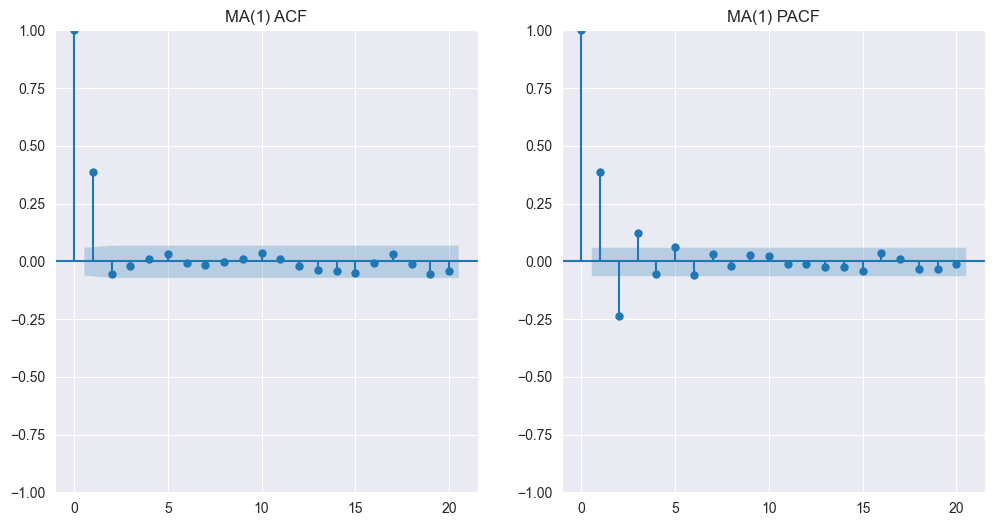

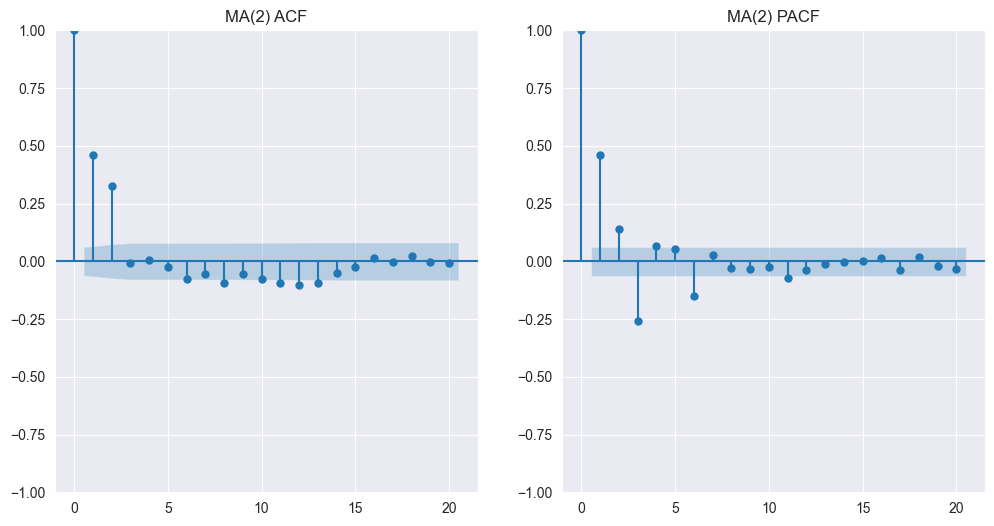

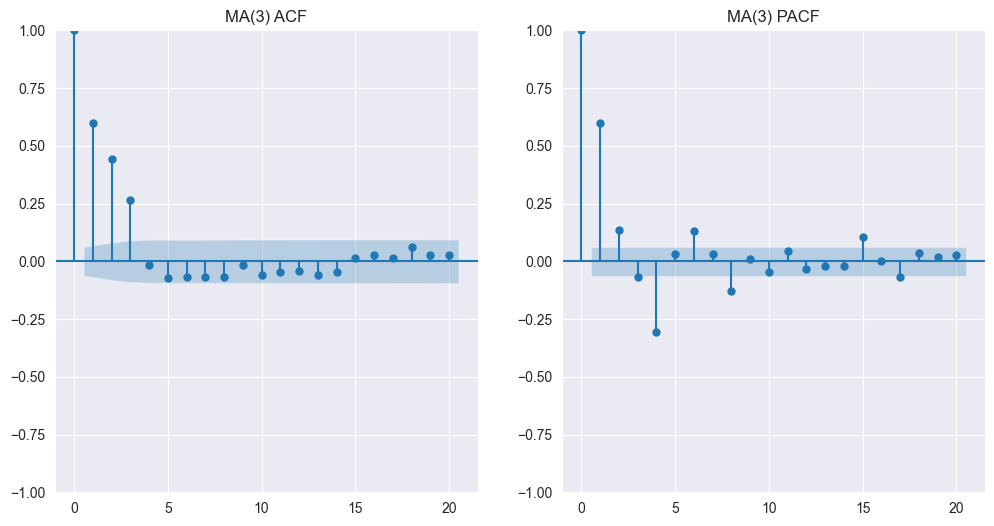

In [22]:
# A. Simulate MA(1), MA(2), MA(3) processes and plot ACF and PACF
def simulate_ma(q, n=1000):
    ma_params = np.zeros(q + 1)
    ma_params[0] = 1  # MA(0) = 1 for identification
    ma_params[1:] = 0.5  # Set MA coefficients to 0.5
    ma_process = ArmaProcess(ma=ma_params)
    simulated_data = ma_process.generate_sample(nsample=n)
    return simulated_data

def plot_acf_pacf(data, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=20, ax=plt.gca(), title=f"{title} ACF")
    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=20, ax=plt.gca(), title=f"{title} PACF")
    plt.show()


# Simulate and plot MA(1), MA(2), MA(3)
for q in [1, 2, 3]:
    ma_data = simulate_ma(q)
    plot_acf_pacf(ma_data, title=f"MA({q})")

From the graphs, we could notice that the ACF truncates after order q and the PACF gradually decays, which satisfy the ACF and PACF properties of the MA process.

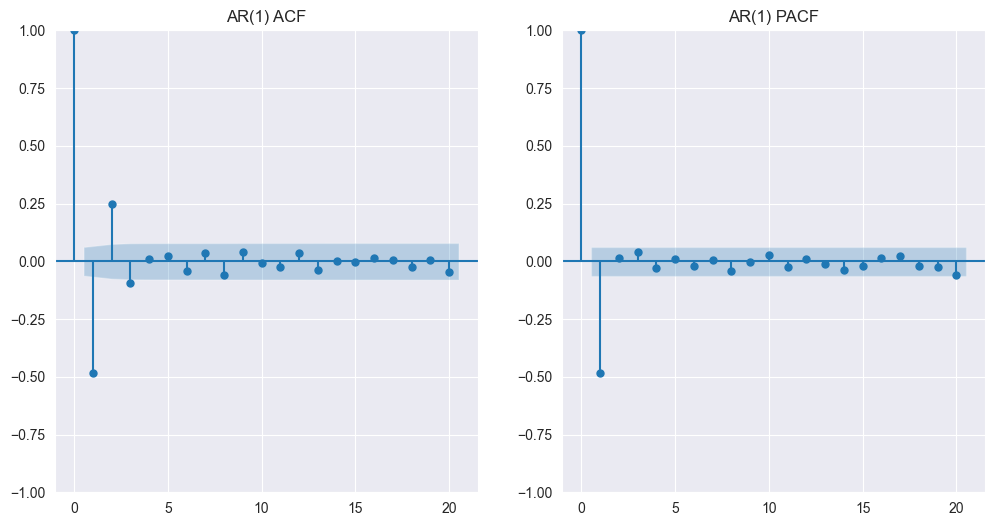

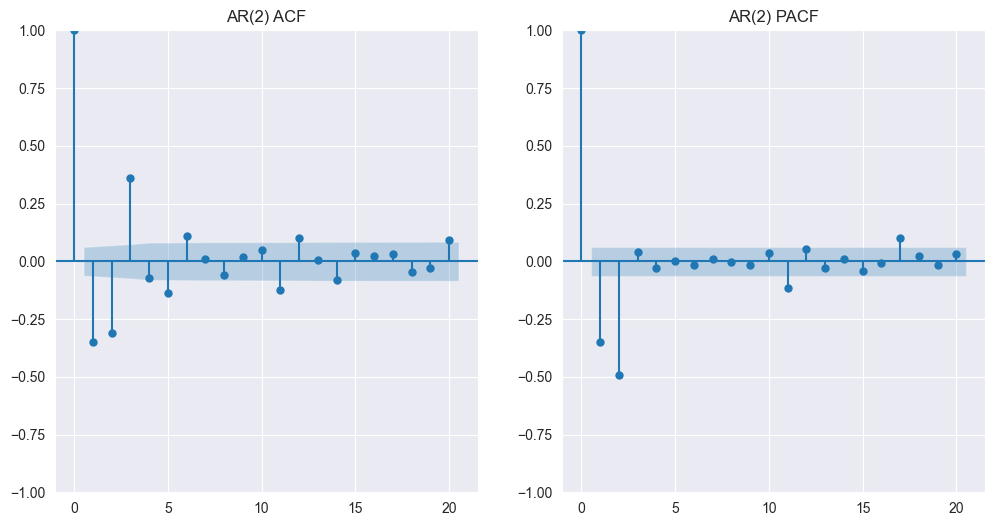

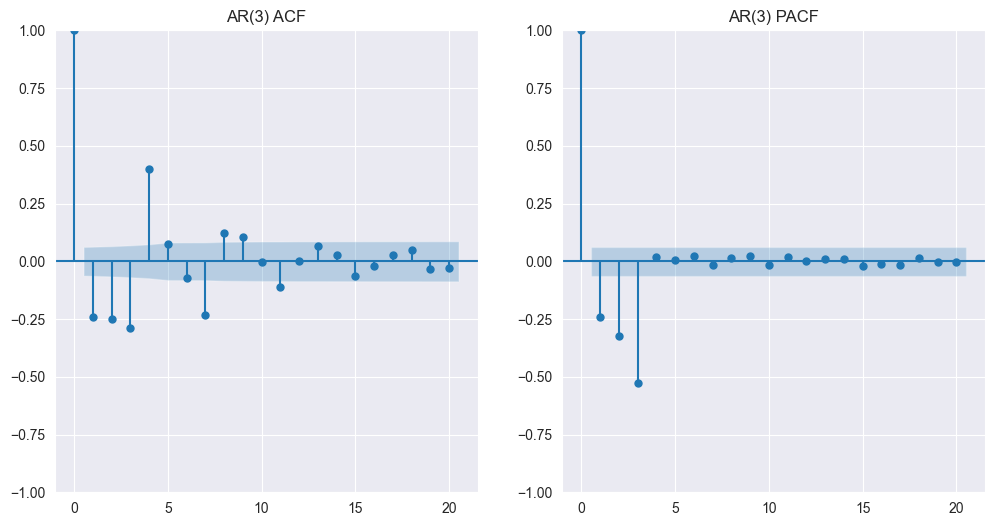

In [23]:
# B. Simulate AR(1), AR(2), AR(3) processes and plot ACF and PACF
def simulate_ar(p, n=1000):
    ar_params = np.zeros(p + 1)
    ar_params[0] = 1  # AR(0) = 1 for identification
    ar_params[1:] = 0.5  # Set AR coefficients to 0.5
    ar_process = ArmaProcess(ar=ar_params)
    simulated_data = ar_process.generate_sample(nsample=n)
    return simulated_data

# Simulate and plot AR(1), AR(2), AR(3)
for p in [1, 2, 3]:
    ar_data = simulate_ar(p)
    plot_acf_pacf(ar_data, title=f"AR({p})")


For AR(1), the ACF gradually decays, while the PACF shows a significant spike at lag 1, indicating its dependence on past direct values. In AR(2), the ACF decays more slowly, while the PACF has a significant spike at lags 1 and 2, reflecting a dependence on the two most recent observations. Similarly, for AR(3), the ACF decays more slowly, while the PACF shows distinct spikes at lags 1, 2, and 3, consistent with a third-order AR process.

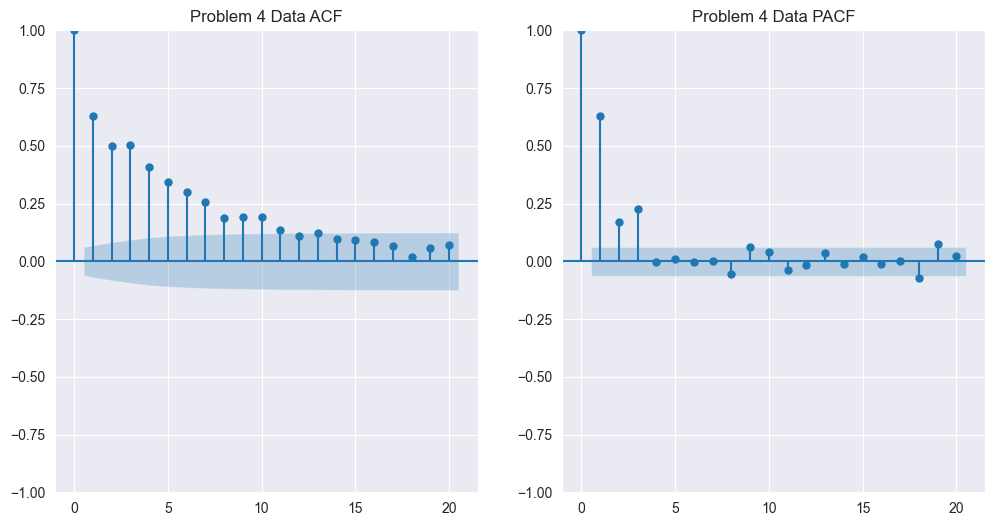

In [24]:
# C. Examine data and identify AR/MA process
plot_acf_pacf(data['y'], title="Problem 4 Data")

Result: The PACF truncates after lag 3, while the ACF gradually decays. So the AR(3) model should be chosen.

In [26]:
# Initialize a list to store results
aic_values = []

# Loop through AR orders (0-3) and MA orders (0-3)
for ar_order in range(4):
    for ma_order in range(4):
        try:
            # Fit the ARMA model for each combination of AR and MA orders
            model = ARIMA(data, order=(ar_order, 0, ma_order))
            result = model.fit()
            # Store the AIC value with the corresponding (AR order, MA order)
            aic_values.append((ar_order, ma_order, result.aic))
        except Exception as e:
            # If the model fails to fit, append a None for AIC value
            aic_values.append((ar_order, ma_order, None))

# Convert the results to a DataFrame for better visualization
aic_df = pd.DataFrame(aic_values, columns=["AR Order", "MA Order", "AIC"])
print(aic_df)

# Find the best model with the lowest AIC value
best_model = aic_df.loc[aic_df['AIC'].idxmin()]
print(f"Best model: AR({best_model['AR Order']}), MA({best_model['MA Order']}) with AIC = {best_model['AIC']}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


    AR Order  MA Order          AIC
0          0         0 -1162.397518
1          0         1 -1508.927033
2          0         2 -1559.250932
3          0         3 -1645.132969
4          1         0 -1669.089267
5          1         1 -1723.454539
6          1         2 -1728.894414
7          1         3 -1744.140141
8          2         0 -1696.091685
9          2         1 -1725.465935
10         2         2 -1740.046363
11         2         3 -1742.580430
12         3         0 -1746.281721
13         3         1 -1744.309922
14         3         2 -1742.372427
15         3         3 -1740.525912
Best model: AR(3.0), MA(0.0) with AIC = -1746.2817209033037


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Based on the comparison of AICc values, the ARMA(3,0) model provides the best fit for data, with the lowest AICc value of -1746.28.

## Problem 5

Given the stock return data in DailyReturns.csv.

A. Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify it produces the expected results from the
testdata folder.

B. Vary λ. Use PCA and plot the cumulative variance explained of λ in (0,1) by each
eigenvalue for each λ chosen.

C. What does this tell us about the values of λ and the effect it has on the covariance
matrix?

In [2]:
import pandas as pd
import numpy as np

In [3]:
def exponential_weights(n, lambda_):
    weights = (1 - lambda_) * (lambda_ ** np.arange(n - 1, -1, -1))
    weights /= weights.sum()  # Normalize weights to sum to 1
    return weights


def exponential_weighted_covariance(data, lambda_):
    if isinstance(data, pd.DataFrame):
        data = data.values

    n, m = data.shape
    weights = exponential_weights(n, lambda_)

    # Center the data (subtract the mean)
    centered_data = data - np.mean(data, axis=0)

    # Calculate the weighted covariance matrix
    cov_matrix = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            cov_matrix[i, j] = np.sum(weights * centered_data[:, i] * centered_data[:, j])

    return cov_matrix

dailyReturn = pd.read_csv("../Projects/Project01/DailyReturn.csv", index_col='Date', parse_dates=True)
lambda_val = 0.97

# Calculate the exponentially weighted covariance matrix
cov_matrix = exponential_weighted_covariance(dailyReturn, lambda_val)
print("Exponentially Weighted Covariance Matrix with 0.97 lambda:")
print(cov_matrix)

Exponentially Weighted Covariance Matrix with 0.97 lambda:
[[7.22898672e-05 5.42719158e-05 1.25794884e-04 ... 6.02118473e-05
  1.28030564e-04 5.23812959e-05]
 [5.42719158e-05 1.39649533e-04 4.24840975e-05 ... 6.11708118e-05
  8.50356109e-05 3.75287951e-05]
 [1.25794884e-04 4.24840975e-05 6.69825413e-04 ... 1.92295240e-05
  3.26380029e-04 4.83209496e-05]
 ...
 [6.02118473e-05 6.11708118e-05 1.92295240e-05 ... 2.53803118e-04
  8.77734377e-05 8.71821118e-05]
 [1.28030564e-04 8.50356109e-05 3.26380029e-04 ... 8.77734377e-05
  7.41543403e-04 7.25493470e-05]
 [5.23812959e-05 3.75287951e-05 4.83209496e-05 ... 8.71821118e-05
  7.25493470e-05 1.53399334e-04]]


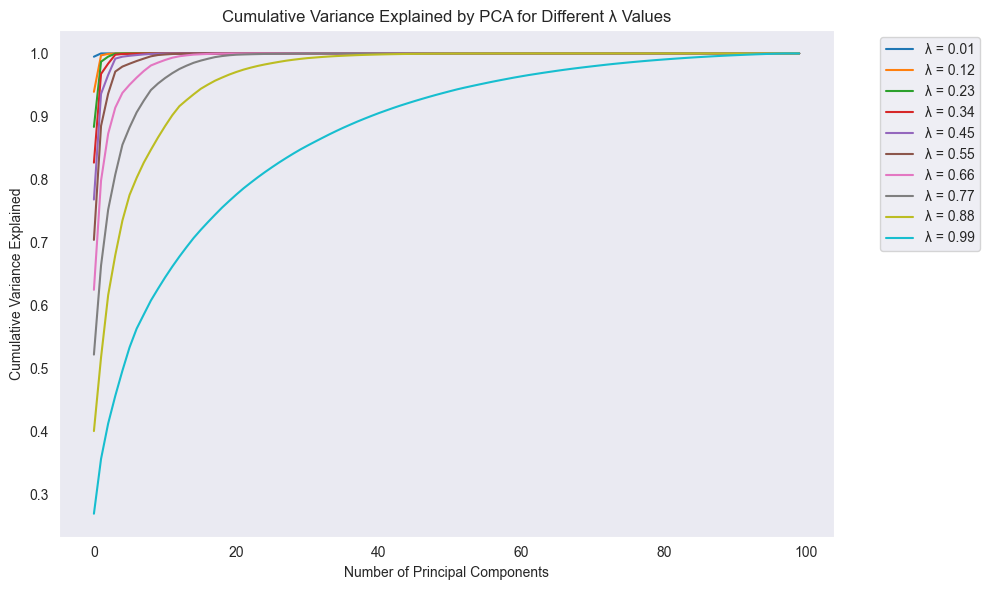

In [7]:
import matplotlib.pyplot as plt
# Function to perform PCA and calculate cumulative variance explained
from sklearn.decomposition import PCA

def pca_cumulative_variance(cov_matrix):
    eigenvalues, _ = np.linalg.eigh(cov_matrix)
    eigenvalues = np.sort(eigenvalues)[::-1]  # Sort in descending order
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    return cumulative_variance

# Vary λ and compute cumulative variance explained
lambdas = np.linspace(0.01, 0.99, 10)  # Range of λ values
cumulative_variances = []

for lambda_ in lambdas:
    cov_matrix = exponential_weighted_covariance(dailyReturn, lambda_)
    cumulative_variance = pca_cumulative_variance(cov_matrix)
    cumulative_variances.append(cumulative_variance)
    # print("With lambda of ", lambda_, " cumulative variance is ", cumulative_variance)

# Plot cumulative variance explained for each λ
plt.figure(figsize=(10, 6))
for i, lambda_ in enumerate(lambdas):
    plt.plot(cumulative_variances[i], label=f"λ = {lambda_:.2f}")

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by PCA for Different λ Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()

In [89]:
# # Verify
# test_pca = pd.read_csv("../testfiles/data/test5_2.csv")
# lambda_val = 0.97
# test_cov_matrix = exponential_weighted_covariance(test_pca, lambda_val)
# test_cumulative_variance = pca_cumulative_variance(test_cov_matrix)
# print("Cumulative Variance Explained by PCA for 0.97 lambda:")
# print(test_cumulative_variance)

Cumulative Variance Explained by PCA for 0.97 lambda:
[0.99388218 0.99999448 0.99999998 1.         1.        ]


### part_c
λ controls the weight given to recent versus historical data.
A higher λ (e.g., 0.99) gives more weight to recent data, resulting in a smoother covariance matrix that is less sensitive to recent fluctuations.

A lower λ (e.g., 0.01) gives more weight to historical data, making the covariance matrix more sensitive to recent changes in the data.

Each λ value affects the computation of the covariance matrix and thus the proportion of variance explained by the principal components. Larger values of λ result in a more even distribution of variance across principal components, requiring more components to explain the same amount of variance. In contrast, smaller values of λ concentrate variance in fewer principal components, allowing the first few components to explain a larger proportion of the total variance.

## Problem 6

Implement a multivariate normal simulation using the Cholesky root of a covariance matrix.

Implement a multivariate normal simulation using PCA with percent explained as an input.

Using the covariance matrix found in problem6.csv

A.  Simulate 10,000 draws using the Cholesky Root method.

B. Simulate 10,000 draws using PCA with 75% variance

C. Take the covariance of each simulation. Compare the Frobenius norm of these matrices
to the original covariance matrix. What do you notice?

D. Compare the cumulative variance explained by each eigenvalue of the 2 simulated
covariance matrices along with the input matrix. What do you notice?

E. Compare the time it took to run both simulations.

F . Discuss the tradeoffs between the two methods.

In [47]:
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, eigvalsh
from scipy.optimize import minimize

def nearest_posdef(A, epsilon=1e-10):
    n = A.shape[0]
    eigval, eigvec = np.linalg.eigh(A)
    eigval[eigval < epsilon] = epsilon # Set negative eigenvalues to zero
    return eigvec @ np.diag(eigval) @ eigvec.T

# Load the covariance matrix from problem6.csv
cov_matrix = pd.read_csv("../Projects/Project01/problem6.csv", parse_dates=True).values

# Adjust the covariance matrix to be positive definite
cov_matrix_adj = nearest_posdef(cov_matrix)

# Verify that the adjusted matrix is positive definite
eigenvalues = eigvalsh(cov_matrix_adj)
print("Adjusted Matrix Eigenvalues:", eigenvalues)
print("Is Adjusted Matrix SPD?", np.all(eigenvalues > 0))

# Perform Cholesky decomposition on the adjusted matrix
L = cholesky(cov_matrix_adj, lower=True)

# Simulate 10,000 draws using Cholesky method
n_samples = 10000
n_variables = cov_matrix.shape[0]
Z = np.random.normal(size=(n_variables, n_samples))  # Standard normal draws
X_cholesky = np.dot(L, Z).T  # Transform using Cholesky root

print("Cholesky Simulation Shape:", X_cholesky.shape)

Adjusted Matrix Eigenvalues: [9.99999858e-11 9.99999875e-11 9.99999879e-11 9.99999894e-11
 9.99999897e-11 9.99999902e-11 9.99999906e-11 9.99999909e-11
 9.99999912e-11 9.99999914e-11 9.99999916e-11 9.99999920e-11
 9.99999921e-11 9.99999922e-11 9.99999924e-11 9.99999925e-11
 9.99999929e-11 9.99999931e-11 9.99999931e-11 9.99999933e-11
 9.99999934e-11 9.99999936e-11 9.99999936e-11 9.99999938e-11
 9.99999939e-11 9.99999940e-11 9.99999942e-11 9.99999943e-11
 9.99999945e-11 9.99999946e-11 9.99999948e-11 9.99999949e-11
 9.99999950e-11 9.99999951e-11 9.99999952e-11 9.99999953e-11
 9.99999953e-11 9.99999954e-11 9.99999955e-11 9.99999955e-11
 9.99999957e-11 9.99999958e-11 9.99999959e-11 9.99999960e-11
 9.99999961e-11 9.99999962e-11 9.99999962e-11 9.99999963e-11
 9.99999963e-11 9.99999965e-11 9.99999966e-11 9.99999967e-11
 9.99999967e-11 9.99999968e-11 9.99999969e-11 9.99999969e-11
 9.99999970e-11 9.99999971e-11 9.99999971e-11 9.99999972e-11
 9.99999972e-11 9.99999973e-11 9.99999974e-11 9.99999974

In [48]:
from sklearn.decomposition import PCA

# Perform PCA on the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Find the number of components needed to explain 75% variance
n_components = np.argmax(cumulative_variance >= 0.75) + 1

# Select top k eigenvalues and eigenvectors
eigenvalues_k = eigenvalues[:n_components]
eigenvectors_k = eigenvectors[:, :n_components]

# Simulate 10,000 draws
Z_pca = np.random.normal(size=(n_components, n_samples))  # Standard normal draws
X_pca = np.dot(eigenvectors_k, np.sqrt(np.diag(eigenvalues_k)) @ Z_pca).T

print("PCA Simulation Shape:", X_pca.shape)

PCA Simulation Shape: (10000, 500)


In [49]:
# Compute covariance matrices of the simulations
cov_cholesky = np.cov(X_cholesky, rowvar=False)
cov_pca = np.cov(X_pca, rowvar=False)

# Compute Frobenius norms
frobenius_cholesky = np.linalg.norm(cov_cholesky - cov_matrix, ord="fro")
frobenius_pca = np.linalg.norm(cov_pca - cov_matrix, ord="fro")

print("Frobenius Norm (Cholesky):", frobenius_cholesky)
print("Frobenius Norm (PCA):", frobenius_pca)

Frobenius Norm (Cholesky): 0.02179562160305022
Frobenius Norm (PCA): 0.08316923525944199


The Frobenius norm of the Cholesky method is small (0.0218):
This indicates that the covariance matrix simulated by the Cholesky method is very close to the original covariance matrix.
The Cholesky method retains the complete structure of the original covariance matrix and therefore the simulation results are more accurate.

The Frobenius norm of the PCA method is larger (0.0832):
This indicates that the covariance matrix simulated by the PCA method is more different from the original covariance matrix.
The PCA method loses some information by dimensionality reduction (only 75% of the variance is retained), so the simulation results are more different from the original matrix.


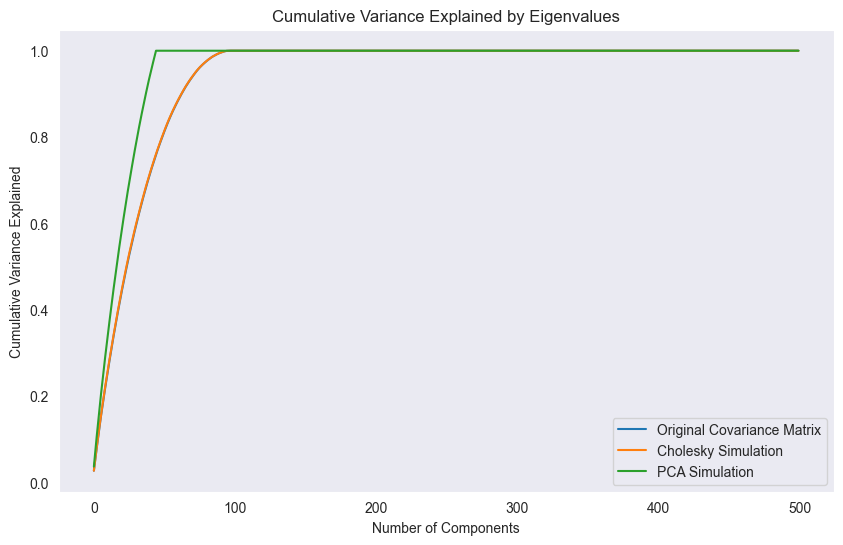

In [52]:
# Compute eigenvalues of simulated covariance matrices
eigenvalues_cholesky, _ = np.linalg.eigh(cov_cholesky)
eigenvalues_pca, _ = np.linalg.eigh(cov_pca)

# Sort eigenvalues in descending order
eigenvalues_cholesky = np.sort(eigenvalues_cholesky)[::-1]
eigenvalues_pca = np.sort(eigenvalues_pca)[::-1]

# Compute cumulative explained variance
cumulative_variance_original = np.cumsum(eigenvalues) / np.sum(eigenvalues)
cumulative_variance_cholesky = np.cumsum(eigenvalues_cholesky) / np.sum(eigenvalues_cholesky)
cumulative_variance_pca = np.cumsum(eigenvalues_pca) / np.sum(eigenvalues_pca)

# Plot cumulative variance explained
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_original, label="Original Covariance Matrix")
plt.plot(cumulative_variance_cholesky, label="Cholesky Simulation")
plt.plot(cumulative_variance_pca, label="PCA Simulation")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by Eigenvalues")
plt.legend()
plt.grid()
plt.show()

The Cholesky Simulation (orange line) is very close to the original (blue line, which is covered by orange line), indicating that the Cholesky method does a great job of preserving the structure of the original covariance matrix, maintaining a very similar variance explanation curve.

The PCA Simulation (green line) explains only 75% of the variance by design, so the curve flattens out earlier, showing a more pronounced drop in variance explained after the first few components. PCA's dimensionality reduction leads to some loss of information, which is evident in the variance explained by each component.

In [53]:
import time

# Time Cholesky simulation
start_time = time.time()
X_cholesky = np.dot(L, np.random.normal(size=(n_variables, n_samples))).T
cholesky_time = time.time() - start_time

# Time PCA simulation
start_time = time.time()
Z_pca = np.random.normal(size=(n_components, n_samples))
X_pca = np.dot(eigenvectors_k, np.sqrt(np.diag(eigenvalues_k)) @ Z_pca).T
pca_time = time.time() - start_time

print("Cholesky Simulation Time:", cholesky_time)
print("PCA Simulation Time:", pca_time)

Cholesky Simulation Time: 0.11326003074645996
PCA Simulation Time: 0.015511035919189453


Cholesky Method took significantly more time than the PCA Method. This difference in time is expected because the Cholesky method requires performing matrix decompositions (Cholesky decomposition) and generating correlated random samples, which can be computationally expensive, especially as the number of components or the matrix size increases. The PCA method typically involves dimensionality reduction, which is less computationally demanding.

The Cholesky simulation is more accurate in preserving the structure of the original covariance matrix, but it requires more computational effort.
The PCA simulation is faster but loses some of the covariance structure due to dimensionality reduction, leading to less accurate results in terms of matching the original matrix.